In [42]:
import sys
sys.path.append('../')

import os
import numpy as np
import matplotlib.pyplot as plt
from plot_grid import plot_grid
import physical_units_diffusion as pud

### The forbidden loop (scary)

In [2]:
for i in range(5):
    j=0
    flag = True
    while flag:
        j += 1
        if j == 20:
            flag = False
            print("break")
    else:
        print("while")
        continue
else:
    print("for")


break
while
break
while
break
while
break
while
break
while
for


In [37]:
# set up toy system
num_steps = 10
grid_size = [30, 10]

n_types = 9 # number of particle types

diffusion_probability = np.array([0, 3, 2, 0.05, 1, 0.03, 0, 0, 0])
diffusion_probability = diffusion_probability/max(diffusion_probability)/5

binding_probability = np.zeros((n_types, n_types))
binding_probability[1, 2] = 0.6 # chemokine binds to netrin
binding_probability[2, 1] = 0.6
binding_probability[2, 6] = 0.9 # netrin binds to collagen site 
binding_probability[6, 2] = 0.9 # netrin binds to collagen site 
binding_probability[1, 3] = 0.3 # chemokine binds to heparansulfate
binding_probability[3, 1] = 0.3
binding_probability[4, 6] = 0.9 # chemokine-netrin binds to collagen_site 
binding_probability[6, 4] = 0.9 # chemokine-netrin binds to collagen_site 
binding_probability[:, 0] = 1 # all particles bind to empty grid site
binding_probability[0, :] = 1 # all particles bind to empty grid site

binding_probability = binding_probability/np.max(binding_probability*diffusion_probability)/4

initial_positions = np.random.choice([0, 1, 2, 3, 4, 5], size=(grid_size[0], grid_size[1]), p=[0.5, 0.1, 0.08, 0.3, 0.01, 0.01])



type_tags = np.arange(1, n_types+1) # 1 = chemokine, 2 = netrin, ...
n_all = np.zeros(n_types, dtype=int) # number of particles of each type

l_x = initial_positions.shape[0]
l_y = initial_positions.shape[1]

# create coordinates (= indices) list for every particle type
pos_idx_all = [np.zeros((l_x*l_y, 2), dtype=int) for _ in range(n_types)]

# fill coordinate lists and find number of particles
for i in range(l_x):
    for j in range(l_y):
        for k, tag in enumerate(type_tags):
            if initial_positions[i, j] == tag:  
                pos_idx_all[k][n_all[k]] = [i, j]
                n_all[k] += 1

# delete empty entries in coordinate lists
for k in range(n_types):
    pos_idx_all[k] = pos_idx_all[k][:n_all[k]]

1.125


### Test get_neighbours()

In [7]:
from monte_carlo_chemokine import _get_neighbours

pos = np.array([[1,2,3],[4, 5, 6], [7, 8, 9]])

print("positions:")
print(pos, "\n")

pos_idx = np.array([0, 2])
reflection_x = True
l_x = pos.shape[0]

neighbours = np.zeros((pos.shape[0], pos.shape[1], 4), dtype=int)

neighbours[i, j] = _get_neighbours(pos, pos_idx, reflection_x, l_x=l_x)

print(f"neighbours of particle {pos_idx}:")
print(neighbours, "\n")


positions:
[[1 2 3]
 [4 5 6]
 [7 8 9]] 

neighbours of particle [0 2]:
[[[0 0 0 0]
  [0 0 0 0]
  [6 0 1 2]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]] 



### Test get transition probs

In [10]:
from monte_carlo_chemokine import _get_transition_prob

transition_probability = np.zeros(5)
transition_probability = _get_transition_prob(initial_positions, pos_idx_all[0][0], transition_probability, diffusion_probability, binding_probability, reflection_x = True, l_x = l_x)
print("transition probability:")
print(transition_probability, "\n")
print("sum of transition probability:")
print(np.sum(transition_probability), "\n")
print("positions of type 1:")
print(pos_idx_all[0], "\n")

transition probability:
[0.000e+00 0.000e+00 2.500e-04 2.500e-04 9.995e-01] 

sum of transition probability:
1.0 

positions of type 1:
[[ 0  0]
 [ 1  0]
 [ 2  3]
 [ 2  5]
 [ 4  1]
 [ 4  5]
 [ 6  8]
 [ 7  1]
 [ 7  3]
 [ 8  1]
 [ 8  7]
 [ 9  3]
 [10  5]
 [14  2]
 [14  7]
 [14  8]
 [16  0]
 [16  1]
 [16  7]
 [17  6]
 [18  6]
 [20  1]
 [20  5]
 [22  9]
 [25  2]
 [25  6]
 [25  7]
 [26  0]
 [26  2]
 [26  7]
 [27  6]
 [28  7]
 [28  8]
 [29  1]] 



### Plot frame

All positions:


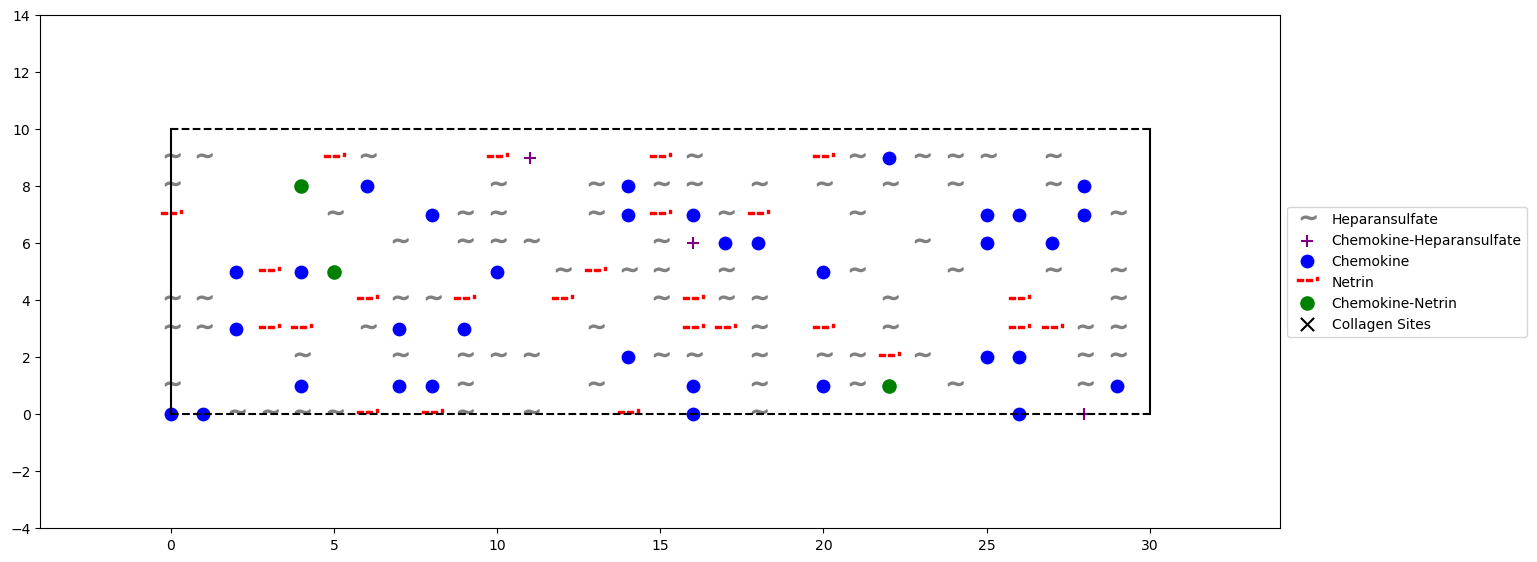

Transition probability for particle 0 of type 1:
[0.000e+00 0.000e+00 2.500e-04 2.500e-04 9.995e-01] 

Position of this particle:


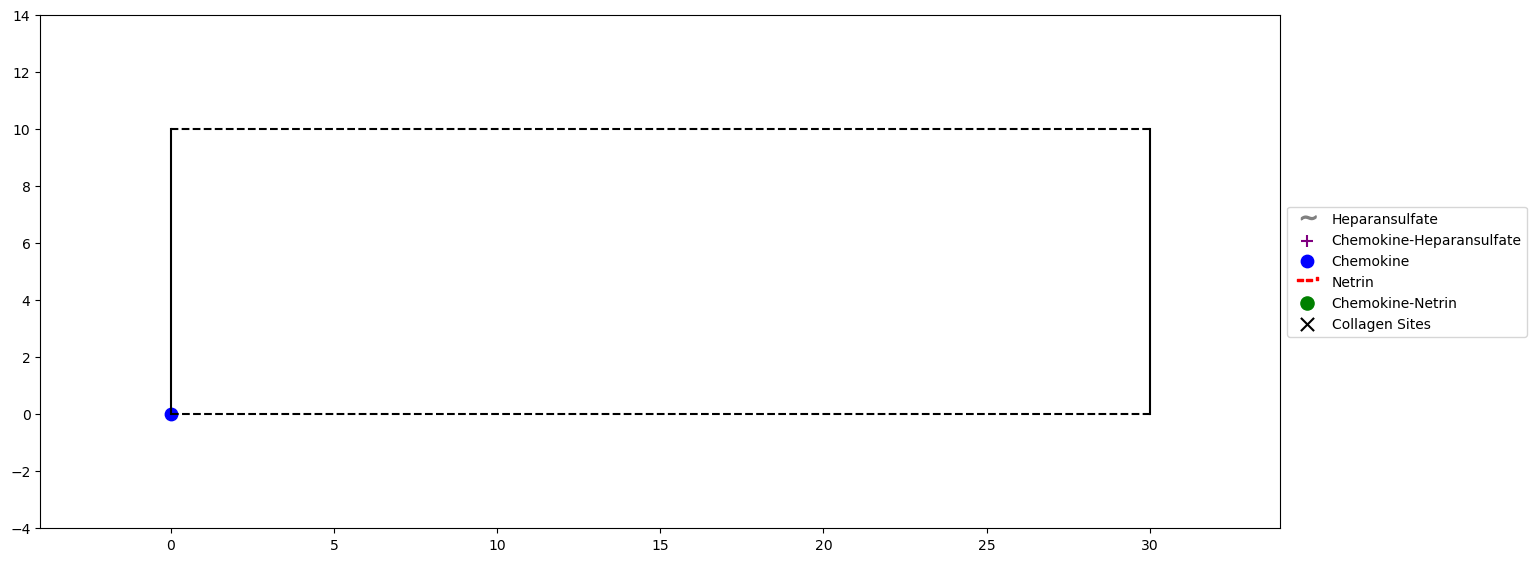

In [31]:
# find indices of particle type

print("All positions:")
plot_grid(initial_positions)

pos_idx_1 = np.where(initial_positions == 1)
pos_1 = np.zeros_like(initial_positions)
pos_1[pos_idx_1] = initial_positions[pos_idx_1]
#plot_grid(pos_1)
pos_2 = np.zeros_like(initial_positions)
pos_2[pos_idx_all[0][0][0], pos_idx_all[0][0][0]] = 1
print("Transition probability for particle 0 of type 1:")
transition_probability = np.zeros(5)
transition_probability = _get_transition_prob(initial_positions, pos_idx_all[0][0], transition_probability, diffusion_probability, binding_probability, reflection_x = True, l_x = l_x)
print(transition_probability, "\n")
print("Position of this particle:")
plot_grid(pos_2)


### Move particle

In [95]:
step_choice = np.array([[1, 0], [-1, 0], [0, 1], [0, -1], [0, 0]]) 

for i in range(10000):
    shift = step_choice[np.random.choice(5, p=transition_probability)]
    if shift[1] == -1:
        break
    
pos_idx = pos_idx_all[0][0]
new_pos_idx = pos_idx + shift

new_pos_idx_wrapped = new_pos_idx%[l_x, l_y]

print(transition_probability)
print(pos_idx)
print(shift)
print(new_pos_idx)
print(new_pos_idx_wrapped)

[0.000e+00 0.000e+00 2.500e-04 2.500e-04 9.995e-01]
[0 0]
[ 0 -1]
[ 0 -1]
[0 9]


In [107]:
x = [[[1,2],[3,4]], [[5,6],[7,8]]]
print(x)
print([1,2] in x)
print([[1,2],[3,4]] in x)
y = np.array(x)
print()
print([1,2] in y)
print([1,3] in y)
print([1,4] in y)
print()
pos_moved = np.zeros_like(initial_positions, dtype=bool)
pos_moved[0, 1] = True
print(np.sum(pos_moved))
print(pos_moved.shape)
pos_moved.fill(False)
print(np.sum(pos_moved))
print(pos_moved.shape)

[[[1, 2], [3, 4]], [[5, 6], [7, 8]]]
False
True

True
True
True

1
(30, 10)
0
(30, 10)


In [59]:
# test unbinding
neighbours = np.array([1, 0, 0, 1], dtype=int)

step_choice = np.array([[1, 0], [-1, 0], [0, 1], [0, -1], [0, 0]]) 

unbond_type_idx = np.zeros((n_types, 2), dtype=int)
unbond_type_idx[4] = [1, 2] # chemokine-netrin -> chemokine + netrin
unbond_type_idx[5] = [1, 3] # chemokine-heparansulfate -> chemokine + heparansulfate
# collagen is not allowed to move, so only chemokine-netrin can hop off
unbond_type_idx[7] = [4, 6] # chemokine-netrin-collagen_site -> chemokine-netrin + collagen_site
# NOTE: in the above case, is it possible for only chemokine to hop off?
unbond_type_idx[8] = [2, 6] # netrin-collagen_site -> netrin + collagen_site

tag = 7
idx_x = 12
idx_y = 0
l_x = 30
l_y = 10
step = 5
trajectory = np.zeros((num_steps, l_x, l_y), dtype=int)

p = neighbours==0
num_no_neighbours = p.sum()


ncase1 = 0
ncase2 = 0
T = np.array([0.5, 0.5])

for i in range(100000):
    pp = np.random.rand()
    A = pp < num_no_neighbours*diffusion_probability[unbond_type_idx[tag][0]]/binding_probability[*unbond_type_idx[tag]]
    B = pp < num_no_neighbours*diffusion_probability[unbond_type_idx[tag][1]]/binding_probability[*unbond_type_idx[tag]]
    C = pp < num_no_neighbours*diffusion_probability[unbond_type_idx[tag]]/binding_probability[*unbond_type_idx[tag]]
    D = num_no_neighbours*diffusion_probability[unbond_type_idx[tag]]/binding_probability[*unbond_type_idx[tag]]
    E = pp < T
    # if C[0] or C[1]:
    #     ncase1 += 1
    # if np.random.rand() < D[0] or np.random.rand() < D[1]:
    #     ncase2 += 1
    if E[0] or E[1]:
        ncase1 += 1
    if np.random.rand() < T[0] or np.random.rand() < T[1]:
        ncase2 += 1
    xx = np.random.choice(2, size=2, replace=False)
    if xx[0] == xx[1]:
        print("Wrong")

print(ncase1)
print(ncase2)

if True:
    print(1)
elif True:
    print(2)



if 0 in neighbours:
    idx_no_nieghbours = neighbours==0
    num_no_neighbours = p.sum()
    
    # decide which particle type gets checked for unbonding first
    tag_1st, tag_2nd = unbond_type_idx[tag][np.random.choice(2, size=2, replace=False)]

    for tag_move in [tag_1st, tag_2nd]:
        # if the barticle did not unbond yet
        if not pos_moved[idx_x, idx_y]:
            p_unbond = 
    
    # roll if unbinding happens
    # check for both possible unbonding types
    #! is this ok???
    if np.random.rand() < num_no_neighbours*diffusion_probability[tag_1st]/binding_probability[tag_1st, tag_2nd]:
        # roll in which direction to go
        step_idx = np.random.choice(4, p=p/num_no_neighbours)
        
        # update position and wrap around
        new_idx_x = (idx_x + step_choice[step_idx, 0])%l_x
        new_idx_y = (idx_y + step_choice[step_idx, 1])%l_y

        # update trajectory
        trajectory[step, idx_x, idx_y] = tag_2nd # leave 2nd particle on same spot
        trajectory[step, new_idx_x, new_idx_y] = tag_1st # move 1st particle to new spot
    
        
        # mark particles as moved
        pos_moved[idx_x, idx_y] = True
        pos_moved[new_idx_x, new_idx_y] = True
        
        
    elif np.random.rand() < num_no_neighbours*diffusion_probability[tag_2nd]/binding_probability[tag_1st, tag_2nd]:
        # roll in which direction to go
        step_idx = np.random.choice(4, p=p/num_no_neighbours)
        
        # update position and wrap around
        new_idx_x = (idx_x + step_choice[step_idx, 0])%l_x
        new_idx_y = (idx_y + step_choice[step_idx, 1])%l_y
        
        # update trajectory
        trajectory[step, idx_x, idx_y] = tag_2nd # leave 2nd particle on same spot
        trajectory[step, new_idx_x, new_idx_y] = tag_1st # move 1st particle to new spot
        
        # mark particles as moved
        pos_moved[idx_x, idx_y] = True
        pos_moved[new_idx_x, new_idx_y] = True

49808
75206
1


In [60]:
def _unbonding_prob(pos, i, j, tag_move, tag_stay, neighbours, transition_prob, diffusion_probability_move, binding_probability, reflection_x: bool = True, l_x: int = None):
    
    
    binding_probability = binding_probability[tag_move, tag_stay]
    # check for (un)allowed moves
    if reflection_x:
        if idx_x == 0:
            neighbours[0] = pos[:, idx_y].take(idx_x+1, mode="wrap") # +x
            neighbours[1] = 1 # wall                                                   # -x    
        elif idx_x == l_x-1:
            neighbours[0] = 1 # wall                                                   # +x
            neighbours[1] = pos[:, idx_y].take(idx_x-1, mode="wrap") # -x
        else:
            neighbours[[0,1]] = pos[:, idx_y].take([idx_x+1, idx_x-1], mode="wrap") # +x, -x
        
        neighbours[[2,3]] =  pos[idx_x, :].take([idx_y+1, idx_y-1], mode="wrap") # +y, -y
    else:  
        neighbours[[0,1]] = pos[:, idx_y].take([idx_x+1, idx_x-1], mode="wrap") # +x, -x
        neighbours[[2,3]] =  pos[idx_x, :].take([idx_y+1, idx_y-1], mode="wrap") # +y, -y
    
    for k, nb in enumerate(neighbours):
        if nb==0:
            transition_prob[k] = diffusion_probability_move/binding_probability
        else:
            transition_prob[k] = 0
    
    # normalize transition probability
    transition_prob[4] = 1 - np.sum(transition_prob[:4])
    
    return transition_prob
    

In [70]:
tb = np.zeros(5)
tag_move, tag_stay = unbond_type_idx[tag][np.random.choice(2, size=2, replace=False)]
tb = _unbonding_prob(initial_positions, idx_x, idx_y, tag_move, tag_stay, neighbours, tb, diffusion_probability[tag_move], binding_probability, reflection_x = True, l_x = l_x)
print(tb)
print(np.sum(tb))

[0. 0. 0. 0. 1.]
1.0


### Test physical units

In [4]:
molecule_mass = [
        15.77, # kDa (CCL5) https://www.rcsb.org/structure/5COY
        50.63, # kDa (Netrin-1) https://www.rcsb.org/structure/4OVE
        500, # kDa (heperansulfate) made up
        15.77 + 50.63,
        500 + 50.63,
        99999999,
        99999999,
        99999999
]

diffusivities = []

for m in molecule_mass:
    diffusivities.append(pud.estimate_diffusivity(m))
    
print(diffusivities)


[1.3273784776637227e-10, 8.997793605645697e-11, 4.1938735768205827e-11, 8.22020489798065e-11, 4.0611782001668246e-11, 7.171422963670905e-13, 7.171422963670905e-13, 7.171422963670905e-13]


In [12]:

traj_dirs = ["/local_scratch2/janmak98/chemokine/results/langmuir_ccl5_netrin_all_logscale/trajectories",
             "/local_scratch2/janmak98/chemokine/results/langmuir_ccl5_netrin_only_logscale/trajectories"]
system_paths = []
for traj_dir in traj_dirs:
    system_paths.append(os.path.join(traj_dir, os.pardir+"/test"))
print(system_paths)    

# os.makedirs(system_paths[0])


['/local_scratch2/janmak98/chemokine/results/langmuir_ccl5_netrin_all_logscale/trajectories/../test', '/local_scratch2/janmak98/chemokine/results/langmuir_ccl5_netrin_only_logscale/trajectories/../test']


In [22]:
print(2**4)
a = np.array([1, 2, 3], dtype=np.int)

a[0] = 255
print(type(a[0]))

16


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [41]:
A = np.zeros(5, dtype=bool)
B = np.zeros(5, dtype=bool)
C = np.zeros(5, dtype=bool)
D = np.zeros(5, dtype=bool)

A[0] = True
B[1] = True
C[[1, 3]] = True
D[4] = True
print(A)
print(A+B)
print(A|B)
print(A+B+C)
print(A|B|C)
print(A+B+C+D)
print(A+B+C | D)
print(A+B | C | D)
print(A | B | C | D)
print(np.any(A))

[ True False False False False]
[ True  True False False False]
[ True  True False False False]
[ True  True False  True False]
[ True  True False  True False]
[ True  True False  True  True]
[ True  True False  True  True]
[ True  True False  True  True]
[ True  True False  True  True]
True


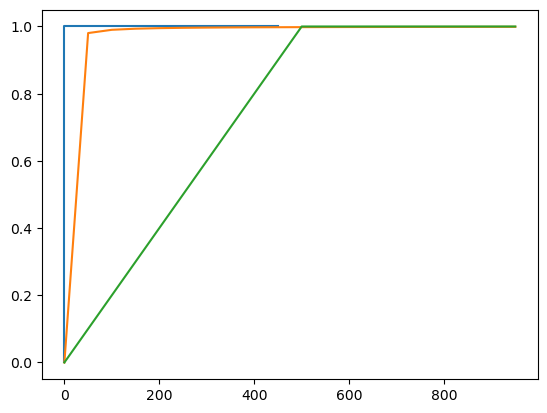

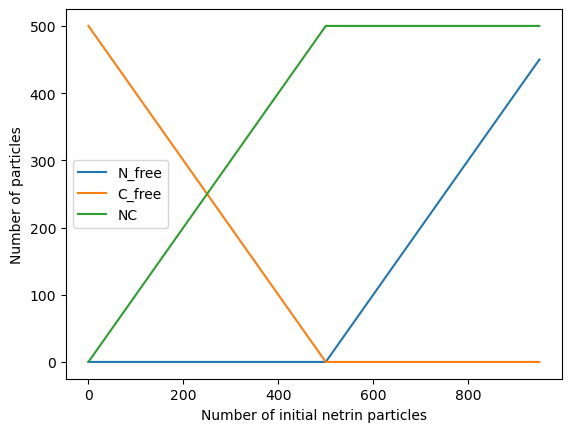

In [53]:
N = np.arange(0, 1000, 50)

N = np.logspace(0, 3, 100)
C = 500

N_free = (N-C)*((N-C)>0)
C_free = (C-N)*((C-N)>0)
 
NC = N*(N<=C) + C*(N>C)

plt.figure()
plt.xscale("log")
plt.plot(N_free, NC/(NC+C_free))

plt.plot(N, N/(N+1))
plt.plot(N, NC/(NC+C_free))
plt.show()

plt.figure()
plt.plot(N, N_free, label="N_free")
plt.plot(N, C_free, label="C_free")
plt.plot(N, NC, label="NC")
plt.legend()
plt.ylabel("Number of particles")
plt.xlabel("Number of initial netrin particles")
plt.show()